In [215]:
import re
import json
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pomegranate as pg

%config InlineBackend.figure_format = 'svg'

split = 'test'

topk_paths = 30
num_states = 15
num_clusters = 150
agent_percent = 0.15

cluster_parent_dir = '../tmobile/cluster_assignment/bert-base-uncased_mlm-lemax-merge-num2'


label_path = '../tmobile/metadata/labels5.csv.gz'
ndf_path = '/g/ssli/data/tmcalls/roylu/stats_data/ndf2.pkl'
model_path = f'{cluster_parent_dir}/sshmm/agent_{num_clusters:03}/models/sshmm_{num_states:03}.json'
state_seq_dir = f'{cluster_parent_dir}/state_sequence/agent_{num_clusters:03}/state_{num_states:03}'
msa_path = f'../tmobile/agent_info/msa_{agent_percent}.csv'
lsa_path = f'../tmobile/agent_info/lsa_{agent_percent}.csv'

with open(model_path, 'r') as f:
    model = pg.HiddenMarkovModel.from_json(json.load(f))
    
idx2state = {}
for i, s in enumerate(model.states):
    idx2state[i] = s.name.split('<-')[0].strip()
    
assert len(idx2state) - 2 == num_states
    
print(f'# states = {len(idx2state)-2}')
print(f'# clusters = {num_clusters}')
df_path = f'{state_seq_dir}/agent_{split}.csv'
df = pd.read_csv(df_path, sep='|')

label_df = pd.read_csv(label_path, compression='gzip', sep='|')

with open(ndf_path, 'rb') as f:
    ndf = pickle.load(f)

# states = 15
# clusters = 150


In [216]:
C_sids = label_df[label_df.C != 'skip'].sourcemediaid.tolist()
ndf = ndf[ndf.sourcemediaid.isin(C_sids)]

In [217]:
ncb_cnt = sum(ndf.adjusted_callback_period_days > 2)
cb_cnt = sum(ndf.adjusted_callback_period_days <= 2)
overall_cb_ratio = cb_cnt / (ncb_cnt + cb_cnt)

In [218]:
def collapse(x):
    chrs = ''.join([chr(int(xx)+97) for xx in x.strip().split(',')])
    collapsed_chrs = re.sub(r'(.)\1+', r'\1', chrs)
    collapsed_state_seq = ','.join([idx2state[ord(c)-97] for c in collapsed_chrs])
    return collapsed_state_seq
    

In [219]:
df['collapsed_state_sequence'] = df['state_sequence'].apply(lambda x: collapse(x))
selected_paths = df['collapsed_state_sequence'].value_counts()[:topk_paths].index.tolist()
print(selected_paths)

print(len(df))
df = df[df['collapsed_state_sequence'].isin(selected_paths)]
print(len(df))

['S01,S02,V03,S03', 'S01,S02,V02,T01,S03', 'S01,S02,T03,T05,T01,S03', 'S01,S02,V05,T01,S03', 'S01,V01,S03', 'S01,S02,V06,T02,T01,S03', 'S01,S02,V04,T01,S03', 'S01,S02,V06,T01,S03', 'S01,S02,T03,T04,T01,S03', 'S01,S02,T03,T01,S03', 'S01,S02,V03', 'S01,S02,V03,T01,S03', 'S01,S02,T03,T02,T01,S03', 'S01,S02,T03,T05', 'S01,S02,T03,T05,S03', 'S01,S02,V06,T04,T01,S03', 'S01,S02,V02,T02,T01,S03', 'S01,S02,T03,T04', 'S01,S02,T02,T01,S03', 'S01,S02,V04,T02,T01,S03', 'S01,S02,V07', 'S01,S02,V05,T02,T01,S03', 'S01,S02,T03,T05,T04,T01,S03', 'S01,S02,T03,T05,T02,T01,S03', 'S01,S02,T03,S03', 'S01,V01', 'S01,S02,V02,T01', 'S01,S02,T03,T05,T01', 'S01,S02,T03,T04,T02,T01,S03', 'S01,S02,T03']
112183
104955


In [220]:
msa = pd.read_csv(msa_path, sep='|')
lsa = pd.read_csv(lsa_path, sep='|')

m = msa.sourcemediaid.tolist()
l = lsa.sourcemediaid.tolist()
mdf = df[df.example_id.isin(m)].rename(columns={'example_id': 'sourcemediaid'})
ldf = df[df.example_id.isin(l)].rename(columns={'example_id': 'sourcemediaid'})
mdf = mdf.merge(msa[['sourcemediaid', 'agent_type']], on='sourcemediaid')
ldf = ldf.merge(lsa[['sourcemediaid', 'agent_type']], on='sourcemediaid')

/g/tial/transitory/roylu/miniconda3/envs/conv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [221]:
#print('msa stats')
#print(mdf.call_length.describe())
#print('lsa stats')
#print(ldf.call_length.describe())
#min_seq_len = min(mdf.call_length.quantile(0.1), ldf.call_length.quantile(0.1))
#max_seq_len = max(mdf.call_length.quantile(0.9), ldf.call_length.quantile(0.9))

join_df = pd.concat([mdf, ldf])
#join_df = join_df[(join_df.call_length >= min_seq_len) & (join_df.call_length <= max_seq_len)]
print(join_df.agent_type.value_counts())

lsa_ncb    9679
msa_ncb    6262
lsa_cb     2018
msa_cb      123
Name: agent_type, dtype: int64


In [253]:
seq_dic = {}
seq2agent_cnt = {}
vc = join_df['agent_type'].value_counts()
msa_overall_cb_ratio = vc['msa_cb'] / sum([vc['msa_cb'], vc['msa_ncb']])
lsa_overall_cb_ratio = vc['lsa_cb'] / sum([vc['lsa_cb'], vc['lsa_ncb']])
for seq, g in join_df.groupby('collapsed_state_sequence'):
    dic = {}
    vc = g.agent_type.value_counts()
    if 'msa_cb' not in vc:
        vc['msa_cb'] = 0
    dic['msa'] = vc['msa_cb'] / sum([vc['msa_cb'], vc['msa_ncb']])
    dic['lsa'] = vc['lsa_cb'] / sum([vc['lsa_cb'], vc['lsa_ncb']])
    seq_dic[seq] = dic
        
    seq2agent_cnt[seq] = {
        'msa': vc['msa_cb'] + vc['msa_ncb'],
        'lsa': vc['lsa_cb'] + vc['lsa_ncb'],
    }

In [254]:
lst = []
seq2cnt = {}
for seq, cb2ratio in seq_dic.items():
    for cb, ratio in cb2ratio.items():
        lst.append((seq, cb, ratio))

df3 = pd.DataFrame(lst, columns=['path', 'callback', 'ratio'])
df3

,path,callback,ratio
0,"S01,S02,T02,T01,S03",msa,0.044444
1,"S01,S02,T02,T01,S03",lsa,0.092784
2,"S01,S02,T03",msa,0.062500
3,"S01,S02,T03",lsa,0.371429
4,"S01,S02,T03,S03",msa,0.083333
5,"S01,S02,T03,S03",lsa,0.275862
6,"S01,S02,T03,T01,S03",msa,0.011628
7,"S01,S02,T03,T01,S03",lsa,0.210526
8,"S01,S02,T03,T02,T01,S03",msa,0.028571
9,"S01,S02,T03,T02,T01,S03",lsa,0.150000


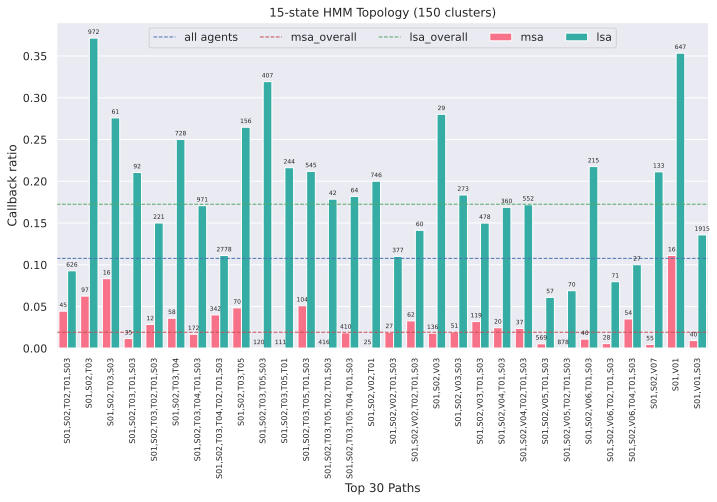

In [259]:
sns.set(rc={'figure.figsize':(11.7, 6)})

g = sns.barplot(
    x='path',
    y='ratio',
    hue='callback',
    data=df3,
    palette = 'husl',  
    capsize = 0.05,             
    saturation = 8,             
    errcolor = 'gray',
    errwidth = 2,  
    ci = 'sd'
)
g.set(
    title=f'{num_states}-state HMM Topology ({num_clusters} clusters)',
    xlabel=f'Top {topk_paths} Paths',
    ylabel='Callback ratio',
)
#g.xaxis.set_label_position('top') 

xticks = plt.xticks()[1]
for i, p in enumerate(g.patches):
    xtick = xticks[i // 2]._text
    agent2cnt = seq2agent_cnt[xtick]
    agent = {0: 'msa', 1: 'lsa'}[i%2]
    cnt = agent2cnt[agent]
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2., height + 0.005, cnt,ha="center", size=6)
    
# specifying horizontal line type
plt.axhline(y=overall_cb_ratio, color='b', linewidth=1, linestyle = 'dashed', label='all agents')
plt.axhline(y=msa_overall_cb_ratio, color='r', linewidth=1, linestyle = 'dashed', label='msa_overall')
plt.axhline(y=lsa_overall_cb_ratio, color='g', linewidth=1, linestyle = 'dashed', label='lsa_overall')
plt.xticks(rotation=90, size=8)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1),
    fancybox=True,
    ncol=5,
)